# LDA (Linear Discriminant Analysis)

In [1]:
import pandas as pd
df = pd.read_csv('dataset1.csv')

In [2]:
df.shape

(768, 9)

**PASO 1: Estandarización del dataset**

La estandarización implica escalar los datos para que cada característica tenga media 0 y desviación estándar 1.

In [3]:
from sklearn.model_selection import train_test_split
X, y = df.iloc[:, 0:-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y, 
                     random_state=0)
# standarize the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

**PASO 2: Cálculo del vector medio para cada clase**

In [4]:
import numpy as np
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [500 268]
Labels counts in y_train: [350 187]
Labels counts in y_test: [150  81]


In [5]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(0, 2):
    mean_vecs.append(np.mean(
        X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 0: [-0.2311 -0.1178 -0.1745 -0.1791 -0.0634 -0.3381 -0.0426 -0.0632]

MV 1: [-0.2311 -0.1178 -0.1745 -0.1791 -0.0634 -0.3381 -0.0426 -0.0632]



Cada uno de los vectores medios obtenidos (MV 0 y MV 1 en este caso) representan el centroide de cada clase en el espacio de características estandarizado, fundamentales para poder calcular las matrices de dispersión entre clases y dentro de las mismas, lo que ayuda a maximizar la separabilidad entre clases.

**PASO 3: Contrucción de las matrices de dispersión dentro y entre clases**

La matriz de dispersión dentro de clases (S_W) representa la variabilidad dentro de cada clase. Si los valores obtenidos en S_W son bajos, se sugiere que la dispersión dentro de las clases es menor.

La matriz de dispersión entre clases (S_B) indica la variabilidad entre cada clase. Si la S_B obtenida es grande en comparación con S_W, se sugiere que las clases están bien clasificadas, lo que facilita la clasificación.

In [6]:
d = 8 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 8x8


In [7]:
print('Class label distribution:',
      np.bincount(y_train))

Class label distribution: [350 187]


In [8]:
d = 8  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print(f'Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 8x8


In [9]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 8  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T)
print('Between-class scatter matrix: ' 
      f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 8x8


**PASO 4: Cálculo de valores y vectores propios**

In [10]:
eigen_vals, eigen_vecs =\
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

Al resolver la ecuación de valores propios para (S_W) ^ -1 * S_B, se obtienen vectores y valores propios que definen las direcciones y magnitudes de máxima separabilidad entre las clases.

Los valores propios obtenidos indican la capacidad de separabilidad de cada dirección encontrada, donde un valor propio grande sugiere que su correspondiente vector propio proporciona una buena discriminación entre clases.

**PASO 5: Ordenación de los valores propios en orden decreciente**

Los valores propios ordenados indican la importancia de cada dirección en términos de discriminabilidad, donde los valores más grandes muestran que las primeras direcciones seleccionadas en LDA capturan mejor la variabilidad entre clases, lo cual es útil para reducir dimensiones sin perder información importante.

In [11]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) 
               for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                     key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

23.417121697885175
7.929516926269009e-16
7.929516926269009e-16
4.46858337266712e-16
3.1491929830047883e-16
2.810786782083204e-16
2.3761644051568856e-17
0.0


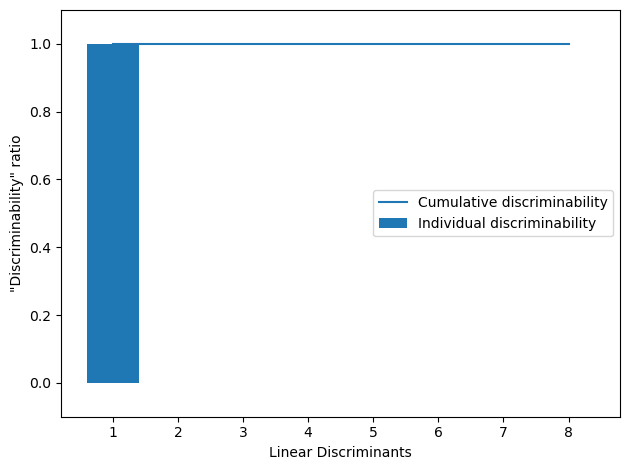

In [12]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real,
                                   reverse=True)]
cum_discr = np.cumsum(discr)
import matplotlib.pyplot as plt
plt.bar(range(1, 9), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 9), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**PASO 6: Selección de los vectores propios más grandes para construir la matriz de transformación**

In [13]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.478  -0.7244]
 [-0.2027  0.2694]
 [-0.1163  0.2531]
 [-0.3161 -0.1459]
 [-0.1376  0.0678]
 [-0.7172  0.332 ]
 [ 0.2123 -0.0999]
 [ 0.1963  0.084 ]]


Como se puede observar, la matriz de transformación W es de tamaño d x k, donde k es el número de dimensiones seleccionadas. Esto permite reducir el espacio de características y maximizar la discriminación entre clases en el espacio transformado.

**PASO 7: Proyección de las muestras en el nuevo subespacio usando la matriz de transformación**

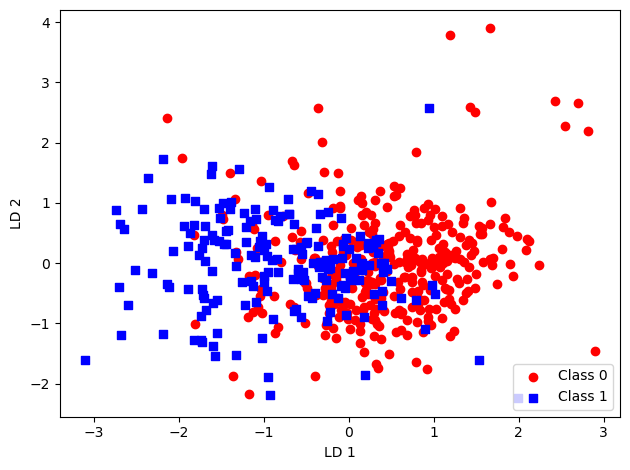

In [14]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1], # * (-1)
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Como se puede observar en el gráfico resultante, las clases deberían aparecer separadas si LDA ha capturado bien las diferencias entre ellas, donde una buena separación visual en las primeras dos componentes discriminantes sugiere que el subespacio reducido es efectivo para clasificar las clases.

**Clasificación y visualización de las regiones de decisión en el subespacio LDA**

Se entrena un clasificador de Regresión Logística en el subespacio LDA y se visualizan las regiones de decisión tanto para el conjunto de entrenamiento como para el conjunto de prueba.

In [15]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

In [16]:
# the following import statement is one line
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components=1)
# X_train_lda = lda.fit_transform(X_train_std, y_train)
# lr = LogisticRegression(multi_class='ovr', random_state=1, 
#                         solver='lbfgs')
# lr = lr.fit(X_train_lda, y_train)
# plot_decision_regions(X_train_lda, y_train, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()

In [17]:
# X_test_lda = lda.transform(X_test_std)
# plot_decision_regions(X_test_lda, y_test, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()